<a href="https://colab.research.google.com/github/w-oke/covid_reproduction/blob/main/covid_owid_2_analysis_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data loaded in this Notebook is based on the output of: covid_owid_1_preparation.ipynb, which can be accessed from:
https://github.com/w-oke/covid_reproduction.

In [1]:
PYTHONHASHSEED=0
import urllib.request
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from tensorflow import keras

In [2]:
df_link = 'https://github.com/w-oke/covid_reproduction/raw/main/covid_owid_df.parquet'
df1 = pd.read_parquet(df_link)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14671 entries, 0 to 14670
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   iso_code                             14671 non-null  object        
 1   location                             14671 non-null  object        
 2   date                                 14671 non-null  datetime64[ns]
 3   reproduction_rate                    14671 non-null  float64       
 4   new_tests_smoothed_per_thousand      14671 non-null  float64       
 5   people_vaccinated_per_hundred        14671 non-null  float64       
 6   people_fully_vaccinated_per_hundred  14671 non-null  float64       
 7   total_boosters_per_hundred           14671 non-null  float64       
 8   stringency_index                     14671 non-null  float64       
 9   population_density                   14671 non-null  float64       
 10  median_age

In [3]:
df1.describe()

,reproduction_rate,new_tests_smoothed_per_thousand,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Alpha,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,non_who,date_diff
count,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000
mean,0.981247,0.024932,0.142838,0.114042,0.021666,0.560950,0.015554,0.473407,0.156399,0.134494,0.681668,0.199699,0.587462,0.590860,0.135999,0.031464,0.278307,0.001583,0.005016,0.021805,0.002054,0.002174,0.006041,0.005961,0.001984,0.510628,0.510624
std,0.309696,0.059803,0.224880,0.209447,0.066831,0.185213,0.078171,0.280223,0.168096,0.241245,0.314402,0.175682,0.230449,0.272662,0.240658,0.101743,0.407454,0.013383,0.031222,0.079873,0.017536,0.019252,0.039937,0.040701,0.019252,0.443168,0.289618
min,-0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.830000,0.002293,0.000000,0.000000,0.000000,0.435200,0.001848,0.208459,0.032584,0.006452,0.443836,0.068613,0.413206,0.355240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026047,0.259259
50%,1.000000,0.009071,0.011376,0.003167,0.000000,0.564800,0.004167,0.468278,0.099553,0.012903,0.858901,0.153285,0.633403,0.632327,0.002397,0.000156,0.000434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500050,0.518519
75%,1.150000,0.025561,0.214730,0.119361,0.003309,0.703700,0.010465,0.740181,0.228384,0.127742,0.906227,0.270073,0.755602,0.813499,0.177391,0.023175,0.732812,0.000137,0.000303,0.012787,0.000101,0.000042,0.003552,0.001837,0.000000,0.999999,0.765432
max,4.190000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# import the dictionary var with lists of features:
var_link = 'https://github.com/w-oke/covid_reproduction/raw/main/covid_owid_var_dictionary.pkl'
a_file = "covid_owid_var_dictionary.pkl"
data = urllib.request.urlretrieve(var_link, a_file) # download the file
with open(a_file, 'rb') as f:
        var = pickle.load(f)

print('The keys of the \'var\' dict are: ', var.keys())
print()
var

The keys of the 'var' dict are:  dict_keys(['y', 'meta', 'number', 'variants', 'scale', 'vaccine', 'imputer_no_date', 'imputer_date'])



{'imputer_date': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  'total_boosters_per_hundred',
  'gdp_per_capita',
  'hospital_beds_per_thousand',
  'stringency_index',
  'date_diff'],
 'imputer_no_date': ['population_density',
  'median_age',
  'gdp_per_capita',
  'extreme_poverty',
  'handwashing_facilities',
  'hospital_beds_per_thousand',
  'life_expectancy',
  'human_development_index'],
 'meta': ['date', 'iso_code', 'location'],
 'number': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  'total_boosters_per_hundred',
  'stringency_index',
  'population_density',
  'median_age',
  'human_development_index',
  'gdp_per_capita',
  'extreme_poverty',
  'handwashing_facilities',
  'hospital_beds_per_thousand',
  'life_expectancy'],
 'scale': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  't

In [5]:
# allocate 20% of the data set to testing
X_train, X_test, y_train, y_test = train_test_split(
                        df1[var['number']+var['variants']], df1[var['y']], 
                        test_size=0.2, random_state=1)

# allocate 25% of the remaining examples (20% of the dataset) to validation
X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [6]:
# create a DNN model with 3 fully connected layers with 128 units each
init = keras.initializers.HeNormal()
model = keras.Sequential([
                keras.layers.Dense(units=128, activation='relu', kernel_initializer=init),
                keras.layers.Dropout(0.15), # adding Dropout layers helps avoid overfitting
                keras.layers.Dense(units=128, activation='relu', kernel_initializer=init),
                keras.layers.Dropout(0.15),
                keras.layers.Dense(units=128, activation='relu', kernel_initializer=init),
                keras.layers.Dropout(0.15),
                keras.layers.Dense(units=1)]) # linear output layer for regression
opt = keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=opt,
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()])

The following hyperparameter values were evaluated, which all resulted in test data RMSE results in the range of 0.2 to 0.29:
* number of Dense layers: 1, 2, 3
* number of units per layer: 64, 128
* optimizer 'adam' and 'sgd'
* keras.layers.Dropout() between layer of 0, 0.1, 0.15, or 0.2
* keras.layers.BatchNormalization() between each layer
* keras.initializers of the default GlorotUniform() and HeNormal()
* training batch size of 16, 24, 32
* keras.callbacks.ReduceLROnPlateau()

The initial value for the learning rate is set at 0.002, and as part of the fit process, the ReduceLROnPlateau callback reduces the learning rate whenever the learning is seen to plateau by a factor of 1/2 until the minimum learning rate of 1e-6 is reached.

In [7]:
early_stopping = keras.callbacks.EarlyStopping(patience=20,
                                               restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                                min_lr=1e-5)
history = model.fit(X_train, y_train,
    batch_size = 32, 	# number of examples in each batch before step
    epochs = 500, 		# will cycle through all trg data 500 times unless:
    callbacks=[early_stopping, lr_schedule], # put callbacks in a list; use lg epochs value
    validation_data = (X_val, y_val)) # to monitor performance

Epoch 1/500
276/276 [==============================] - 2s 3ms/step - loss: 0.1336 - root_mean_squared_error: 0.3655 - val_loss: 0.1074 - val_root_mean_squared_error: 0.3277 - lr: 0.0020
Epoch 2/500
276/276 [==============================] - 1s 3ms/step - loss: 0.1008 - root_mean_squared_error: 0.3175 - val_loss: 0.0924 - val_root_mean_squared_error: 0.3039 - lr: 0.0020
Epoch 3/500
276/276 [==============================] - 1s 3ms/step - loss: 0.0940 - root_mean_squared_error: 0.3065 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2887 - lr: 0.0020
Epoch 4/500
276/276 [==============================] - 1s 3ms/step - loss: 0.0909 - root_mean_squared_error: 0.3015 - val_loss: 0.0809 - val_root_mean_squared_error: 0.2844 - lr: 0.0020
Epoch 5/500
276/276 [==============================] - 1s 3ms/step - loss: 0.0880 - root_mean_squared_error: 0.2967 - val_loss: 0.0802 - val_root_mean_squared_error: 0.2832 - lr: 0.0020
Epoch 6/500
276/276 [==============================] - 1s 3ms/step - l

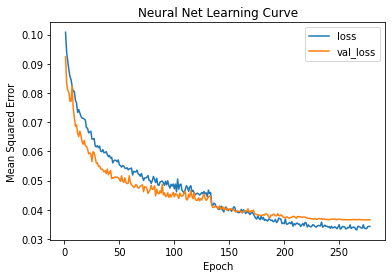

In [8]:
history_df = pd.DataFrame(history.history) # convert the trg history to a DF
fig, ax = plt.subplots(figsize=(6,4))
history_df.loc[1:, ['loss', 'val_loss']].plot(ax=ax)
ax.set(title='Neural Net Learning Curve', xlabel='Epoch', 
       ylabel='Mean Squared Error');

We can see that the model starts to overtrain the training data set at a certain point in the training.

In [9]:
# Calculate the Standard Deviation of y
y_var = float(df1[var['y']].var())
print("The Variance of the Reproduction Rate (the dependent variable) is {:.4f}".format(y_var))
print("The Standard Deviation of the Reproduction Rate (the dependent variable) is {:.4f}".format(np.sqrt(y_var)))

The Variance of the Reproduction Rate (the dependent variable) is 0.0959
The Standard Deviation of the Reproduction Rate (the dependent variable) is 0.3097


In [10]:
mse = model.evaluate(X_test, y_test)[0]

92/92 [==============================] - 0s 1ms/step - loss: 0.0436 - root_mean_squared_error: 0.2089


In [11]:
print('{:.0f}% of the variance in the Reproduction Rate is explained by this model'.format(100*(y_var - mse)/y_var))

55% of the variance in the Reproduction Rate is explained by this model
